In [57]:
from sklearn.model_selection import train_test_split
import pandas as pd
from catboost import CatBoostClassifier
import numpy as np

# get data from csv file on desktop
data = pd.read_csv(r'C:\Users\Alex\Desktop\data_sample_20.csv')

data.head()

,timestamp,user_id,post_id,target,age,text_length,business,covid,entertainment,movie,politics,sport,tech,views,likes,like_percentage
0,1633378097,46109,1,1,24,324,8.0,7.0,10.0,15.0,8.0,13.0,3.0,8508,1067,0.013002
1,1633725339,136803,1,0,19,324,1.0,25.0,4.0,36.0,12.0,18.0,2.0,8508,1067,0.013002
2,1633903307,123995,1,0,45,324,3.0,11.0,2.0,15.0,1.0,0.0,4.0,8508,1067,0.013002
3,1633078406,56308,1,0,23,324,3.0,4.0,5.0,2.0,0.0,3.0,0.0,8508,1067,0.013002
4,1633951376,42615,1,0,22,324,2.0,21.0,5.0,36.0,14.0,9.0,3.0,8508,1067,0.013002


In [58]:
'''Devision for train and test data'''

user_ids = data['user_id'].unique()

# shuffle user ids
np.random.shuffle(user_ids)

# split user ids into train and test
train_user_ids = user_ids[:int(len(user_ids) * 0.8)]

# split data into train and test
train_df = data[data['user_id'].isin(train_user_ids)]
test_df = data[~data['user_id'].isin(train_user_ids)]

# Make sure 'user_id' and 'post_id' are set as index before creating 'X' and 'y'
train_df.set_index(['user_id', 'post_id'], inplace=True)
test_df.set_index(['user_id', 'post_id'], inplace=True)

# split train and test into X and y
X_train = train_df.drop('target', axis=1)
y_train = train_df['target']

X_test = test_df.drop('target', axis=1)
y_test = test_df['target']


In [88]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(
    iterations=500,  # Modify this parameter as needed
    thread_count=8, 
    depth=10,  # Modify this parameter as needed
    learning_rate=0.1,  # Modify this parameter as needed 
    eval_metric='PRAUC',  # Changed to PR AUC
    verbose=100,  # Output the training process every 200 iterations
    random_seed=42
)

# Fit model
model.fit(X_train, y_train, eval_set=(X_test, y_test))


0:	learn: 0.1669926	test: 0.1638460	best: 0.1638460 (0)	total: 521ms	remaining: 4m 20s
100:	learn: 0.1863634	test: 0.1812293	best: 0.1812293 (100)	total: 1m 24s	remaining: 5m 31s
200:	learn: 0.1943553	test: 0.1826232	best: 0.1826235 (199)	total: 2m 48s	remaining: 4m 11s
300:	learn: 0.2022917	test: 0.1829516	best: 0.1829516 (300)	total: 4m 13s	remaining: 2m 47s
400:	learn: 0.2106343	test: 0.1828014	best: 0.1830000 (340)	total: 5m 39s	remaining: 1m 23s
499:	learn: 0.2174983	test: 0.1828603	best: 0.1830000 (340)	total: 7m 5s	remaining: 0us

bestTest = 0.1830000377
bestIteration = 340

Shrink model to first 341 iterations.


In [92]:
# Save model
model.save_model('catboost_model.cbm', format='cbm')

In [93]:
from_file = CatBoostClassifier()
from_file.load_model('catboost_model.cbm', format='cbm')
from_file.get_params()
from_file.predict_proba(X_test)

array([[0.95261071, 0.04738929],
       [0.84549883, 0.15450117],
       [0.76297423, 0.23702577],
       ...,
       [0.97836117, 0.02163883],
       [0.88671247, 0.11328753],
       [0.95833371, 0.04166629]])

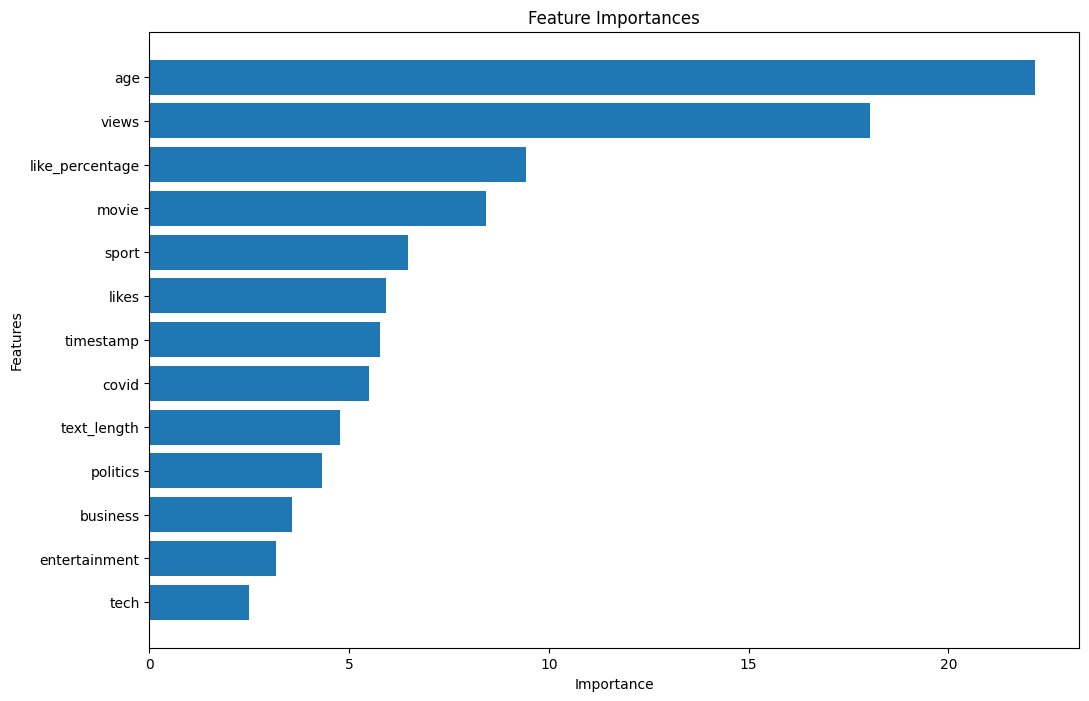

In [89]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = model.get_feature_importance()

# Create a pandas dataframe for easier visualization
importance_df = pd.DataFrame({
    'Features': X_train.columns,
    'Importance': feature_importances
})

# Sort the dataframe based on the feature importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Features'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()



In [90]:
def hitrate5(model, X, Y):
    check = pd.concat([Y,
                       pd.Series(model.predict_proba(X)[:,1], index=Y.index, name='probas')],
                      axis=1)
    check = check.reset_index().drop(columns='post_id')
    
    pred_list = [check[check.user_id == user_id].sort_values('probas', ascending=False).iloc[:5]
                 for user_id in check.user_id.unique()]

    return pd.concat(pred_list).groupby('user_id').target.sum().map(lambda x: min(1, x)).mean()

print('Hitrate@5: {:.4f}'.format(hitrate5(model, X_test, y_test)))

Hitrate@5: 0.6304
